In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import gc
import random
import warnings
import pickle
import importlib
warnings.filterwarnings(action='ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
torch.manual_seed(1015)
# define 'device' to upload tensor in gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import sklearn
from sklearn.neighbors import KNeighborsRegressor

# 상위 폴더에서 module을 import하기 위해 시스템 경로에 상위 폴더의 경로를 추가
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 


from utils.preprocess_utils import *
from utils.train_utils import *
from models.model_cycle.cycle_lstm import LSTMModel_cycle

In [3]:
### morning data
with open('../data/preprocess/l_data_list.pkl', 'rb') as f:
#with open('data/preprocess/l_data_list.pkl', 'rb') as f:
#with open('data/preprocess/e_data_list.pkl', 'rb') as f:
#with open('data/preprocess/full_data_list.pkl', 'rb') as f:
    data_list = pickle.load(f)

#print(data_list[1].shape)
data_list = append_cycle_size(data_list)
#print(data_list[1].shape)

train_time, train_notime, train_y,\
valid_time, valid_notime, valid_y, \
    test_time, test_notime, test_y = numpy2tensor(data_list)

In [4]:
# load model
model = LSTMModel_cycle(input_size = 10, hidden_size = 32, no_time_size = 4).to(device)
# set model
criterion = nn.MSELoss(size_average = True)


train_error = []
valid_error = []

hist = {'best_val_error': 100,
        'best_val_epoch': 0}
start_epochs = 0
num_epochs = 0

In [5]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.5e-2)

run_epochs = 110
num_epochs += run_epochs
for t in range(start_epochs, num_epochs):
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    # model.hidden = model.init_hidden()  
    # Forward pass

    train_pred = model(train_time, train_notime)
    loss = criterion(train_pred, train_y[:,:,1])
    train_error.append(loss)

    valid_pred = model(valid_time, valid_notime)
    valid_mse = float(criterion(valid_pred, valid_y[:,:,1]).cpu())
    valid_error.append(valid_mse)

    # Zero out gradient, else they will accumulate between epochs
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    if hist['best_val_error'] >= valid_mse:
        hist['best_val_error'] = valid_mse
        hist['best_val_epoch'] = t
        best_model = model

    if t % 10 == 0 and t !=0:
        print(f"{t} Epochs train MSE: {loss.item():1.5f} // valid MSE: {valid_mse:1.5f}")

start_epochs = num_epochs

10 Epochs train MSE: 0.01800 // valid MSE: 0.01041
20 Epochs train MSE: 0.01775 // valid MSE: 0.01023
30 Epochs train MSE: 0.01673 // valid MSE: 0.00997
40 Epochs train MSE: 0.01412 // valid MSE: 0.01043
50 Epochs train MSE: 0.00926 // valid MSE: 0.00797
60 Epochs train MSE: 0.00711 // valid MSE: 0.00608
70 Epochs train MSE: 0.00571 // valid MSE: 0.00559
80 Epochs train MSE: 0.00488 // valid MSE: 0.00567
90 Epochs train MSE: 0.00438 // valid MSE: 0.00564
100 Epochs train MSE: 0.00404 // valid MSE: 0.00572


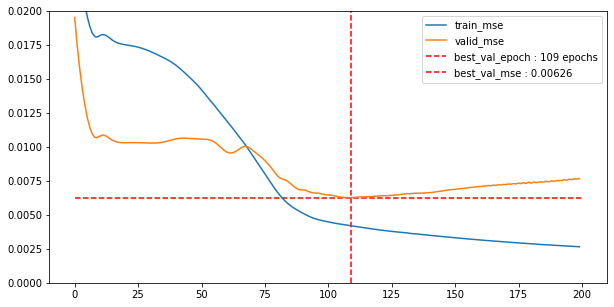

In [13]:

plt.figure(figsize = [10, 5])
plt.plot(train_error, label = 'train_mse')
plt.plot(valid_error, label = 'valid_mse')
plt.vlines(hist['best_val_epoch'], ymin = 0, ymax = 1,
             colors = 'red', ls = 'dashed', label = f"best_val_epoch : {hist['best_val_epoch']} epochs")
plt.hlines(hist['best_val_error'], xmin = 0, xmax = len(train_error),
             colors = 'red', ls = 'dashed', label = f"best_val_mse : {hist['best_val_error']:1.5f}")
plt.xticks(label = 'epochs')
plt.legend()
plt.ylim(0,0.02)
plt.show()

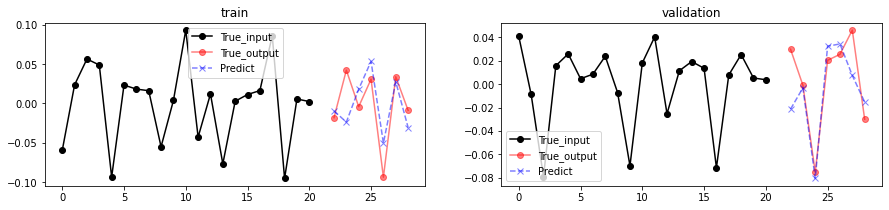

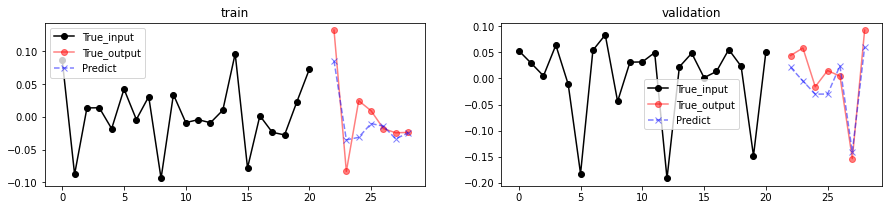

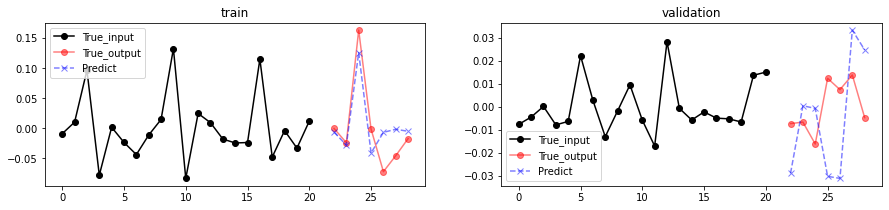

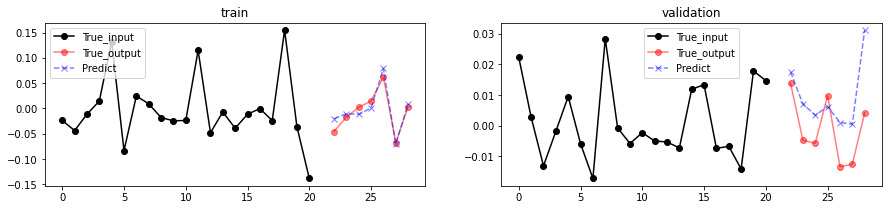

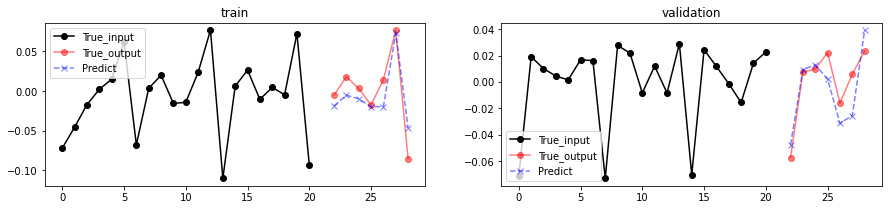

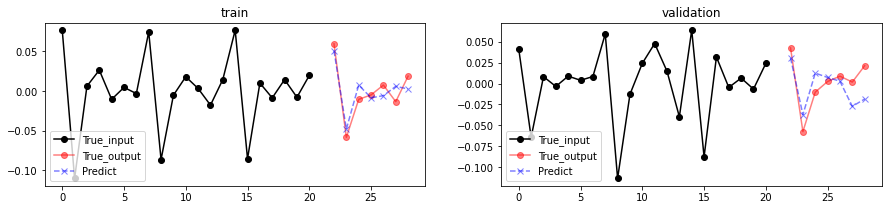

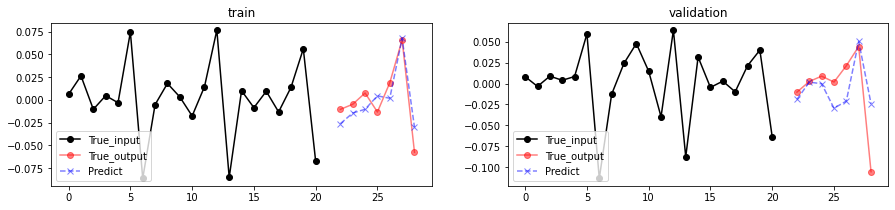

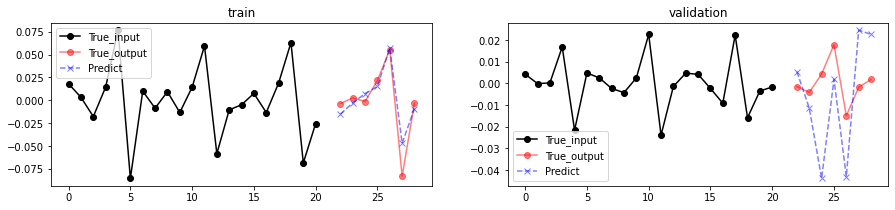

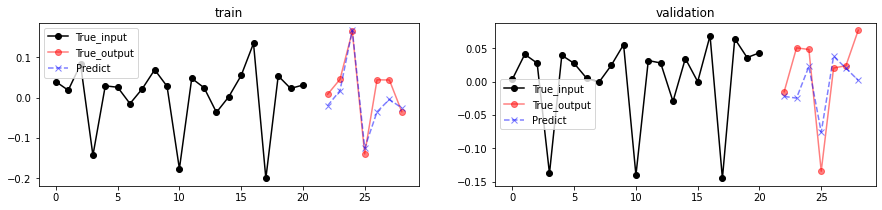

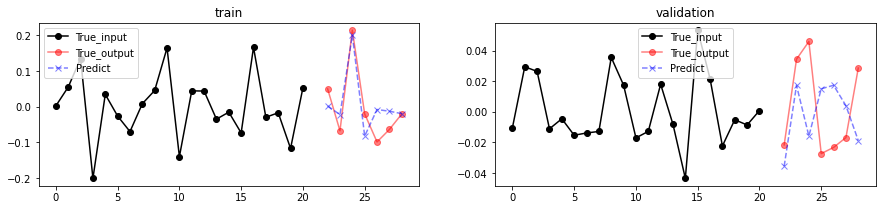

In [8]:
train_pred = best_model(train_time, train_notime)
valid_pred = best_model(valid_time, valid_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
valid_time_x_np, valid_y_np, valid_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        valid_time[:,:,-1], valid_y[:,:,1], valid_pred])
# plot result
plot_predict(train_x_np, train_y_np, train_pred_np,\
                valid_time_x_np, valid_y_np, valid_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    valid_time_x_np, valid_y_np, valid_pred_np]
### morning result
path = '../data/train_results/lunch_results/'
with open(path + 'l_cycle_results_list.pkl', 'wb') as f:
    pickle.dump(cycle_result_list, f)

In [7]:
test_pred = best_model(test_time, test_notime)
criterion(test_pred, test_y[:,:,1])

tensor(0.0047, device='cuda:0', grad_fn=<MseLossBackward>)

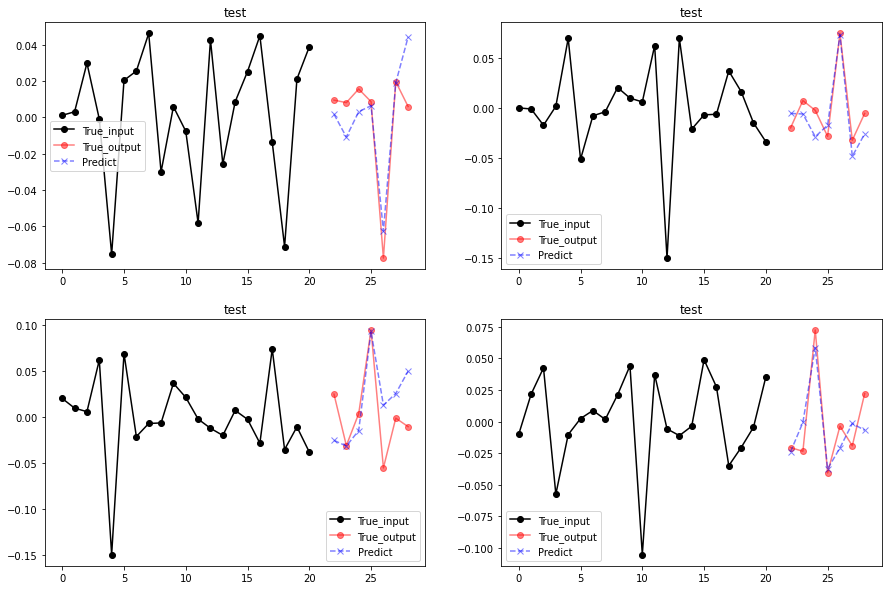

In [6]:
train_pred = best_model(train_time, train_notime)
test_pred = best_model(test_time, test_notime)
# convert result
train_x_np, train_y_np, train_pred_np,\
test_time_x_np, test_y_np, test_pred_np = tensor2numpy([train_time[:,:,-1], train_y[:,:,1], train_pred,
                                                        test_time[:,:,-1], test_y[:,:,1], test_pred])
# plot result
plot_test_predict(test_time_x_np, test_y_np, test_pred_np)

# save result
cycle_result_list = [train_x_np, train_y_np, train_pred_np,\
                    test_time_x_np, test_y_np, test_pred_np]